In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
df = pd.read_csv('training.csv',encoding = 'latin',names = ['sentiment','id','date','query_string','user','text'])

In [3]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.isnull().sum()

sentiment       0
id              0
date            0
query_string    0
user            0
text            0
dtype: int64

Wall time: 225 ms


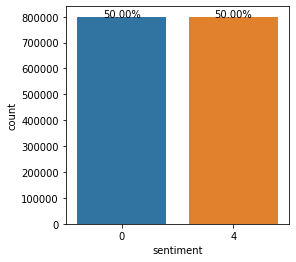

In [5]:
%%time
f, ax = plt.subplots(1,1, figsize=(4*1,4))
# g.set_title("Number and percentage of {}".format(df['sentiment']))
g = sns.countplot(df['sentiment'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/len(df)),
            ha="center")

In [6]:
df['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [7]:
# df['sentiment'] = df['sentiment'].map({'4':1})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment       1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
user            1600000 non-null object
text            1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
df['sentiment'] = df['sentiment'].map({4:1,0:0})

In [10]:
df['sentiment'].value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [11]:
df1 = df.drop(['id','date','query_string','user'],1)

In [12]:
df['text'][1]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

In [13]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

In [14]:
df['date']

0          Mon Apr 06 22:19:45 PDT 2009
1          Mon Apr 06 22:19:49 PDT 2009
2          Mon Apr 06 22:19:53 PDT 2009
3          Mon Apr 06 22:19:57 PDT 2009
4          Mon Apr 06 22:19:57 PDT 2009
                       ...             
1599995    Tue Jun 16 08:40:49 PDT 2009
1599996    Tue Jun 16 08:40:49 PDT 2009
1599997    Tue Jun 16 08:40:49 PDT 2009
1599998    Tue Jun 16 08:40:49 PDT 2009
1599999    Tue Jun 16 08:40:50 PDT 2009
Name: date, Length: 1600000, dtype: object

In [15]:
%%time
FILTER_STEM = True
stop_words = stopwords.words("english")
wordnet = WordNetLemmatizer()
def filter_stopwords(text):
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    if FILTER_STEM:
        return " ".join([wordnet.lemmatize(token) for token in text.split() if token not in stop_words])
    else:
        return " ".join([token for token in text.split() if token not in stop_words])
df.text = df.text.apply(filter_stopwords)

Wall time: 4min 14s


In [16]:
df['text'][1]

'upset update facebook texting might cry result school today also blah'

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [18]:
%%time
tfidf = TfidfVectorizer()
freq = tfidf.fit_transform(df['text'])

Wall time: 38.1 s


In [19]:
freq.shape

(1600000, 323539)

In [20]:
X = freq
y = df['sentiment']

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 42)

In [23]:
from scipy import stats

In [24]:
stats.f_oneway(y_train,y_test,y)

F_onewayResult(statistic=2.0002818754402845, pvalue=0.13529731008128273)

In [25]:
%%time
lr  = LogisticRegression()
y_pred = lr.fit(X_train,y_train).predict(X_test)
accuracy_score(y_test,y_pred)


C:\Users\Swinal Meshram\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 55.8 s


0.77875

In [26]:
confusion_matrix(y_test,y_pred)

array([[120608,  38886],
       [ 31914, 128592]], dtype=int64)

In [27]:
import nltk
def par(paragraph):
    sentences = nltk.sent_tokenize(paragraph)
    corpus = []
    for i in range(len(sentences)):
        review = re.sub('[^a-zA-Z]', ' ', sentences[i])
        review = review.lower()
        review = review.split()
        review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    print(corpus)
    txt = tfidf.transform(corpus)
    print(txt)
    return lr.predict(txt)
    

In [42]:
par("I love someone")

['love someone']
  (0, 262301)	0.8154067794038261
  (0, 171577)	0.5788884038416039


array([1], dtype=int64)

In [29]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,label
0,7921,0
1,7922,0
2,7923,0
3,7924,0
4,7925,0


In [30]:
test = pd.read_csv('test.csv')
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [31]:
test.tweet = test.tweet.apply(filter_stopwords)

In [35]:
test1 = tfidf.transform(test['tweet'])

In [37]:
test1.shape

(1953, 323539)

In [38]:
pred1 = lr.predict(test1)

In [39]:
pred1

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [40]:
sample_sub = pd.DataFrame({'id':test['id'],'label':pred1})
sample_sub.head()

,id,label
0,7921,0
1,7922,0
2,7923,1
3,7924,0
4,7925,0


In [44]:
sample_sub.to_csv('submission.csv',index = False)